In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ipl-2008-to-2021-all-match-dataset/IPL_Ball_by_Ball_2008_2022.csv
/kaggle/input/ipl-2008-to-2021-all-match-dataset/IPL_Matches_2008_2022.csv


# Importing modules

In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the dataset

In [3]:
# Step 1: Load the dataset
file_path = '/kaggle/input/ipl-2008-to-2021-all-match-dataset/IPL_Ball_by_Ball_2008_2022.csv'
ddf = pd.read_csv(file_path)

# Display the first few rows of the dataset
ddf.head()

,ID,innings,overs,ballnumber,batter,bowler,non-striker,extra_type,batsman_run,extras_run,total_run,non_boundary,isWicketDelivery,player_out,kind,fielders_involved,BattingTeam
0,1312200,1,0,1,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,0,0,0,NaN,NaN,NaN,Rajasthan Royals
1,1312200,1,0,2,YBK Jaiswal,Mohammed Shami,JC Buttler,legbyes,0,1,1,0,0,NaN,NaN,NaN,Rajasthan Royals
2,1312200,1,0,3,JC Buttler,Mohammed Shami,YBK Jaiswal,NaN,1,0,1,0,0,NaN,NaN,NaN,Rajasthan Royals
3,1312200,1,0,4,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,0,0,0,NaN,NaN,NaN,Rajasthan Royals
4,1312200,1,0,5,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,0,0,0,NaN,NaN,NaN,Rajasthan Royals


In [4]:
ddf.shape

(225954, 17)

# Preprocessing data

There are a few overs with more than 6 balls (upto 10), we drop those since we don't need to consider them in our dataset.

In [5]:
ddf.rename(columns={'non_boundary': 'boundary'}, inplace=True)

In [6]:
ddf = ddf.drop((ddf.loc[ddf['ballnumber'] > 6].index), axis=0)

In [7]:
ddf.innings.value_counts()

innings
1    112808
2    105163
3        74
4        70
5         6
6         4
Name: count, dtype: int64

In [8]:
ddf = ddf.drop((ddf.loc[ddf['innings'] > 2].index), axis=0)

We engineer a few important features that will be used in this time-series like data.

In [9]:
ddf['total_runs'] = ddf.groupby(['ID', 'innings'])['total_run'].cumsum()
ddf['wickets'] = ddf.groupby(['ID', 'innings'])['isWicketDelivery'].cumsum()
ddf['current_score'] = ddf['total_runs'] + ddf['extras_run']

Calculating and making the `final_score` feature which is our target variable.

In [10]:
grouped_final_scores = ddf.groupby(['ID', 'innings'])['current_score'].transform('max')
ddf['final_score'] = grouped_final_scores
ddf.head()

,ID,innings,overs,ballnumber,batter,bowler,non-striker,extra_type,batsman_run,extras_run,...,boundary,isWicketDelivery,player_out,kind,fielders_involved,BattingTeam,total_runs,wickets,current_score,final_score
0,1312200,1,0,1,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,...,0,0,NaN,NaN,NaN,Rajasthan Royals,0,0,0,130
1,1312200,1,0,2,YBK Jaiswal,Mohammed Shami,JC Buttler,legbyes,0,1,...,0,0,NaN,NaN,NaN,Rajasthan Royals,1,0,2,130
2,1312200,1,0,3,JC Buttler,Mohammed Shami,YBK Jaiswal,NaN,1,0,...,0,0,NaN,NaN,NaN,Rajasthan Royals,2,0,2,130
3,1312200,1,0,4,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,...,0,0,NaN,NaN,NaN,Rajasthan Royals,2,0,2,130
4,1312200,1,0,5,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,...,0,0,NaN,NaN,NaN,Rajasthan Royals,2,0,2,130


In [11]:
ddf = ddf.drop(columns=['total_runs'])

In [12]:
ddf.head()

,ID,innings,overs,ballnumber,batter,bowler,non-striker,extra_type,batsman_run,extras_run,total_run,boundary,isWicketDelivery,player_out,kind,fielders_involved,BattingTeam,wickets,current_score,final_score
0,1312200,1,0,1,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,0,0,0,NaN,NaN,NaN,Rajasthan Royals,0,0,130
1,1312200,1,0,2,YBK Jaiswal,Mohammed Shami,JC Buttler,legbyes,0,1,1,0,0,NaN,NaN,NaN,Rajasthan Royals,0,2,130
2,1312200,1,0,3,JC Buttler,Mohammed Shami,YBK Jaiswal,NaN,1,0,1,0,0,NaN,NaN,NaN,Rajasthan Royals,0,2,130
3,1312200,1,0,4,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,0,0,0,NaN,NaN,NaN,Rajasthan Royals,0,2,130
4,1312200,1,0,5,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,0,0,0,NaN,NaN,NaN,Rajasthan Royals,0,2,130


In [13]:
ddf.player_out = ddf.player_out.fillna('None')
ddf.extra_type = ddf.extra_type.fillna('None')
ddf.fielders_involved = ddf.fielders_involved.fillna('None')
ddf.kind = ddf.kind.fillna('None')

In [14]:
ddf.head()

,ID,innings,overs,ballnumber,batter,bowler,non-striker,extra_type,batsman_run,extras_run,total_run,boundary,isWicketDelivery,player_out,kind,fielders_involved,BattingTeam,wickets,current_score,final_score
0,1312200,1,0,1,YBK Jaiswal,Mohammed Shami,JC Buttler,None,0,0,0,0,0,None,None,None,Rajasthan Royals,0,0,130
1,1312200,1,0,2,YBK Jaiswal,Mohammed Shami,JC Buttler,legbyes,0,1,1,0,0,None,None,None,Rajasthan Royals,0,2,130
2,1312200,1,0,3,JC Buttler,Mohammed Shami,YBK Jaiswal,None,1,0,1,0,0,None,None,None,Rajasthan Royals,0,2,130
3,1312200,1,0,4,YBK Jaiswal,Mohammed Shami,JC Buttler,None,0,0,0,0,0,None,None,None,Rajasthan Royals,0,2,130
4,1312200,1,0,5,YBK Jaiswal,Mohammed Shami,JC Buttler,None,0,0,0,0,0,None,None,None,Rajasthan Royals,0,2,130


In [15]:
ddf = ddf.drop(ddf[ddf['kind'].isin(['retired hurt', 'retired out', 'obstructing the field'])].index, axis=0)

In [16]:
player_le = LabelEncoder()
players = pd.concat([ddf['batter'], ddf['bowler'], ddf['non-striker'], ddf['player_out'], ddf['fielders_involved']]).unique()
players.sort()
player_le.fit(players)
ddf['batter'] = player_le.transform(ddf['batter'])
ddf['bowler'] = player_le.transform(ddf['bowler'])
ddf['non-striker'] = player_le.transform(ddf['non-striker'])
ddf['player_out'] = player_le.transform(ddf['player_out'])
ddf['fielders_involved'] = player_le.transform(ddf['fielders_involved'])

team_le = LabelEncoder()
teams = ddf.BattingTeam.unique()
team_le.fit(teams)
ddf.BattingTeam = team_le.transform(ddf.BattingTeam)

extra_type_le = LabelEncoder()
extra_types = ddf.extra_type.unique()
extra_type_le.fit(extra_types)
ddf.extra_type = extra_type_le.transform(ddf.extra_type)

kind_le = LabelEncoder()
kinds = ddf.kind.unique()
kind_le.fit(kinds)
ddf.kind = kind_le.transform(ddf.kind)

In [17]:
ddf.head()

,ID,innings,overs,ballnumber,batter,bowler,non-striker,extra_type,batsman_run,extras_run,total_run,boundary,isWicketDelivery,player_out,kind,fielders_involved,BattingTeam,wickets,current_score,final_score
0,1312200,1,0,1,649,381,236,0,0,0,0,0,0,404,0,404,13,0,0,130
1,1312200,1,0,2,649,381,236,2,0,1,1,0,0,404,0,404,13,0,2,130
2,1312200,1,0,3,236,381,649,0,1,0,1,0,0,404,0,404,13,0,2,130
3,1312200,1,0,4,649,381,236,0,0,0,0,0,0,404,0,404,13,0,2,130
4,1312200,1,0,5,649,381,236,0,0,0,0,0,0,404,0,404,13,0,2,130


# Splitting the data

In [18]:
X = ddf.drop(columns=['final_score', 'ID'])
y = ddf['final_score']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cross-Validation on different models

### Linear Regression

In [20]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [21]:
y_pred_lin_reg = lin_reg.predict(X_test)
ATrS_lr = lin_reg.score(X_train, y_train)
ATeS_lr = lin_reg.score(X_test, y_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lin_reg))

print("Linear Regression")
print(f"ATrS: {ATrS_lr}")
print(f"ATeS: {ATeS_lr}")
print(f"RMSE: {rmse_lr}")

Linear Regression
ATrS: 0.4247332805610108
ATeS: 0.41922077267158897
RMSE: 21.45985815596486


### XGBRegressor

In [22]:
xgb = XGBRegressor(n_estimators=1000, max_depth=8, learning_rate=0.2)

# param_dist = {
#     'n_estimators': [100, 250, 500, 1000],
#     'max_depth': [3, 4, 5, 6, 7, 8],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
# }

# random_search_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=100, cv=5, random_state=42, n_jobs=-1, verbose=3)

# random_search_xgb.fit(X_train, y_train)

best_model_xgb = xgb.fit(X_train, y_train)

In [23]:
# print(f"Best parameters: {random_search_xgb.best_params_}")
# print(f"Best cross-validation score: {random_search_xgb.best_score_}")

# best_model_xgb = random_search_xgb.best_estimator_
# test_score = best_model_xgb.score(X_test, y_test)
# print(f"Test set score: {test_score}")

# Best parameters: {'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.2}
# Best cross-validation score: 0.9680809797582359
# Test set score: 0.9729918071507653

In [24]:
y_pred = best_model_xgb.predict(X_test)

In [25]:
print('ATrS:', best_model_xgb.score(X_train, y_train))
print('ATeS:', best_model_xgb.score(X_test, y_test))

ATrS: 0.9626582877877543
ATeS: 0.8617999349455348


# Testing on user input

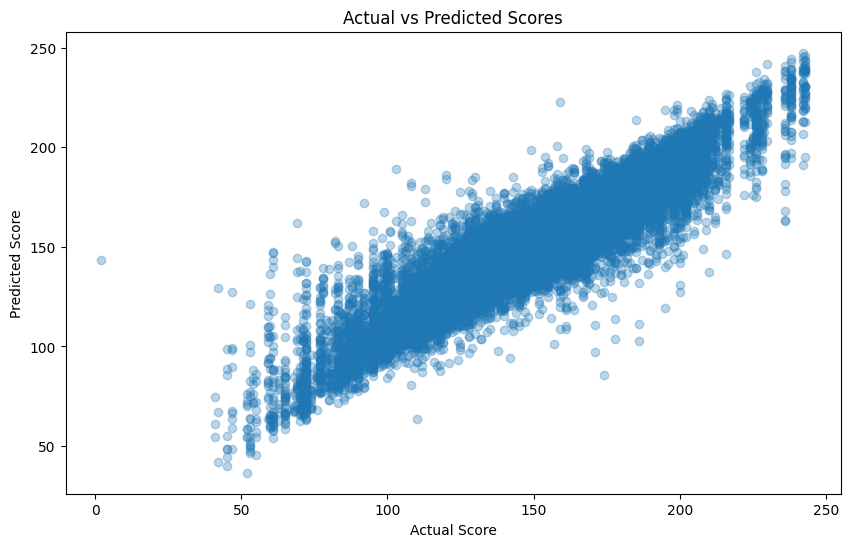

In [26]:
# Step 7: Visualization
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Actual vs Predicted Scores")
plt.show()

In [27]:
# # Save the model
# import joblib
# model_path = 'score_predictor_model.pkl'
# joblib.dump(best_model_xgb, model_path)
# print(f"Model saved to {model_path}")

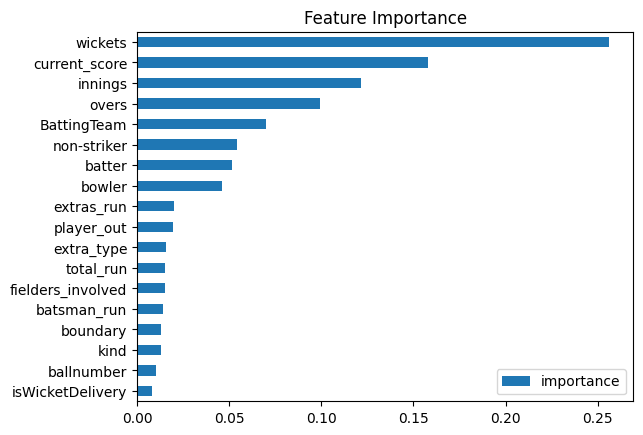

In [28]:
fi = pd.DataFrame(data=best_model_xgb.feature_importances_, columns=['importance'])
fi.index = X.columns
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [29]:
X.columns

Index(['innings', 'overs', 'ballnumber', 'batter', 'bowler', 'non-striker',
       'extra_type', 'batsman_run', 'extras_run', 'total_run', 'boundary',
       'isWicketDelivery', 'player_out', 'kind', 'fielders_involved',
       'BattingTeam', 'wickets', 'current_score'],
      dtype='object')

In [30]:
def process_test_data(df):
    df = df.copy()
    
    df['innings'] = pd.to_numeric(df['innings'])
    df['overs'] = pd.to_numeric(df['overs'])
    df['ballnumber'] = pd.to_numeric(df['ballnumber'])
    
    df['batsman_run'] = pd.to_numeric(df['batsman_run'])
    df['extras_run'] = pd.to_numeric(df['extras_run'])
    df['total_run'] = pd.to_numeric(df['total_run'])
    
    df['boundary'] = df['boundary'].astype('bool')
    df['isWicketDelivery'] = df['isWicketDelivery'].astype('bool')
    
    df['wickets'] = pd.to_numeric(df['wickets'])
    df['current_score'] = pd.to_numeric(df['current_score'])
    
    df['batter'] = player_le.transform(df['batter'])
    df['bowler'] = player_le.transform(df['bowler'])
    df['non-striker'] = player_le.transform(df['non-striker'])
    df['player_out'] = player_le.transform(df['player_out'])
    df['fielders_involved'] = player_le.transform(df['fielders_involved'])
    
    df['kind'] = kind_le.transform(df['kind'])
    df['extra_type'] = extra_type_le.transform(df['extra_type'])
    df['BattingTeam'] = team_le.transform(df['BattingTeam'])

    return df

In [31]:
from IPython.display import display
import ipywidgets as widgets
import pandas as pd
from datetime import datetime


overs_values = [i for i in range(0, 20)]
ballnumber_values = [i for i in range(1, 7)]
wickets_values = [i for i in range(0, 11)]

innings = widgets.Dropdown(options=[1, 2], description='Innings:')
overs = widgets.Dropdown(value=5, options=overs_values, description='Over number:')
ballnumber = widgets.Dropdown(value=4, options=ballnumber_values, description='Ball number:')
batter = widgets.Dropdown(value='MS Dhoni', options=players, description='Batsman: ')
bowler = widgets.Dropdown(value='JJ Bumrah', options=players, description='Bowler:')
non_striker = widgets.Dropdown(value='SK Raina', options=players, description='Non-striker:')
batsman_run = widgets.Dropdown(value=1, options=[0, 1, 2, 3, 4, 5, 6], description='Ballrun:')
extras_run = widgets.IntText(value=0, description='Any extra runs from wide etc: ', disabled=False)
extra_type = widgets.Dropdown(value='None', options=extra_types, description='Extra runs type:')
is_wicket = widgets.Checkbox(value=False, description='Wicket:')
player_out = widgets.Dropdown(value='None', options=players, description='Player out:')
fielders_involved = widgets.Dropdown(value='None', options=players, description='Fielder Involved in Wicket:')
kind = widgets.Dropdown(value='None', options=kinds, description='Wicket kind:')
wickets = widgets.Dropdown(value=4, options=wickets_values, description='Wickets: ')
batting_team = widgets.Dropdown(value='Chennai Super Kings', options=teams, description='Batting Team:')
current_score = widgets.IntText(value=67, description='Current score: ', disabled=False)

prediction_result = widgets.Output()

def handle_prediction(btn):
    with prediction_result:
        prediction_result.clear_output()
        
        boundary = False
        if batsman_run.value in [4, 6]:
            boundary = True
            
        if is_wicket.value:
            for feature in [player_out.value, fielders_involved.value, kind.value]:
                if feature == 'None':
                    print(f'{feature} should be filled correctly!')
        
        if current_score.value < 0:
            print("Invalid score")
        
        test_data = {
            'innings': innings.value,
            'overs': int(overs.value),
            'ballnumber': ballnumber.value,
            'batter': batter.value,
            'bowler': bowler.value,
            'non-striker': non_striker.value,
            'extra_type': extra_type.value,
            'batsman_run': int(batsman_run.value),
            'extras_run': int(extras_run.value),
            'total_run': int(batsman_run.value) + int(extras_run.value),
            'boundary': boundary,
            'isWicketDelivery': is_wicket.value,
            'player_out': player_out.value,
            'kind': kind.value,
            'fielders_involved': fielders_involved.value,
            'BattingTeam': batting_team.value,
            'wickets': int(wickets.value),
            'current_score': int(current_score.value)
        }

        if None in test_data.values():
            print("Please fill all fields.")
            return

        test_data_df = pd.Series(test_data).to_frame().T
        test_data_df = process_test_data(test_data_df)
        print(f"\nProcessed Input Data:\n{test_data_df}")
        print(f"Datatypes:\n{test_data_df.dtypes}")
        prediction = best_model_xgb.predict(test_data_df)
        print(f"\nPredicted score:\n{max(int(prediction[0]), int(current_score.value))}")

predict_button = widgets.Button(description='Predict')
predict_button.on_click(handle_prediction)

input_form = widgets.VBox([
    innings, overs, ballnumber, batter, bowler, non_striker, batsman_run, extra_type, extras_run, is_wicket, player_out, fielders_involved, kind, batting_team,
    current_score, wickets, predict_button, prediction_result
])

display(input_form)